<a href="https://colab.research.google.com/github/cleziac/Movie-Recommendation/blob/main/movie_posters_similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature extraction on movie posters


In [ ]:
# function used to perform data scraping and save the pictures.
# the DF used is to_use_def.

import urllib3
http = urllib3.PoolManager()

urls = list(df['Poster'])
names = list(df['title'])
N = 0 # counter helps me to rename the downloaded files
# print "downloading with urllib"
for url in urls:
    r = http.request('GET',url)
    Name =str(N+1)
    N += 1
    #print(names[N - 1])
    with open("/content/drive/MyDrive/thesis/posters_def/" + names[N-1] + ".jpg", "wb") as fcont:
       fcont.write(r.data)

The images were then resized in order to be fed to the CNN (this was done locally on my machine).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from keras.applications import vgg16
from keras.utils import load_img, img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

In [3]:
imgs_path = "/content/drive/MyDrive/thesis/posters_resized/"
imgs_model_width, imgs_model_height = 224, 224
nb_closest_images = 5

In [4]:
# Step 1 -- load pretrained model from Keras
# -- in this case VGG16 model will be loaded, trained on imagenet
# -- given that I don't want to perform classification,
# -- only retrieve the information that the model was able to
# -- capture from the images, the last layers of the CNN
# -- will be removed (those used for classification purposes).

# load model
vgg_model = vgg16.VGG16(weights='imagenet')

# remove last layers in order to get features
feature_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)

feature_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Appending images in the files variables. The total number of images scraped was 4130, so about 500 were lost but I decided to keep it that way and not manually add them (too time consuming).

In [5]:
files = [imgs_path + x for x in os.listdir(imgs_path) if 'jpg' in x]

print('Number of images:', len(files))

Number of images: 4130


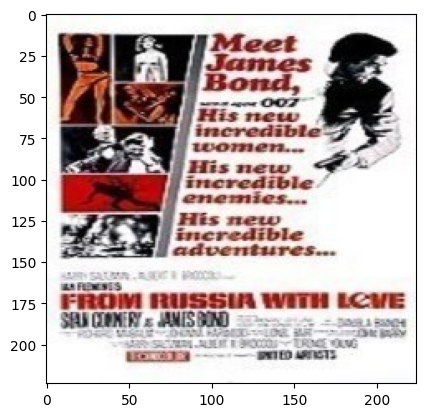

image loaded successfully!


In [6]:
original = load_img(files[0], target_size=(imgs_model_width, imgs_model_height))
plt.imshow(original)
plt.show()
print("image loaded successfully!")

The following piece of code performs the following:

- Convert the PIL image to a numpy array (in PIL the image is formatted as [width, height, channel], while in numpy the image is [height, width, channel];

- Convert the images to a batch format and expand_dims adds an extra dimension to the data on the row axis. The input matrix has to be in the shape [batchsize, height, width, channels];

- Prepare the image for the VGG-16 model.

In [7]:
numpy_image = img_to_array(original)

image_batch = np.expand_dims(numpy_image, axis=0)
print('image batch size', image_batch.shape)

processed_image = preprocess_input(image_batch.copy())

image batch size (1, 224, 224, 3)


Ge the extracted features:

In [8]:
img_features = feature_extractor.predict(processed_image)

print("features successfully extracted!")
print("number of image features:",img_features.size)
img_features

1/1 [==============================] - 7s 7s/step
features successfully extracted!
number of image features: 4096


array([[0.      , 5.09359 , 0.      , ..., 0.      , 0.      , 3.236729]],
      dtype=float32)

Feed the images into the CNN.

In [41]:
importedImages = []

for f in files[3501:4130]:
    filename = f
    original = load_img(filename, target_size=(224, 224))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)

    importedImages.append(image_batch)

images = np.vstack(importedImages)

processed_imgs = preprocess_input(images.copy())

In [42]:
imgs_features = feature_extractor.predict(processed_imgs)

print("features successfully extracted!")
imgs_features.shape

20/20 [==============================] - 5s 285ms/step
features successfully extracted!


(629, 4096)

In [44]:
cosSimilarities8 = cosine_similarity(imgs_features)
cos_similarities_df8 = pd.DataFrame(cosSimilarities8, columns=files[3501:4130], index=files[3501:4130])
cos_similarities_df8.head()

/content/drive/MyDrive/thesis/posters_resized/How to Train Your Dragon 2.jpg  \
/content/drive/MyDrive/thesis/posters_resized/H...                                           1.000000                              
/content/drive/MyDrive/thesis/posters_resized/T...                                           0.308728                              
/content/drive/MyDrive/thesis/posters_resized/S...                                           0.525147                              
/content/drive/MyDrive/thesis/posters_resized/A...                                           0.419589                              
/content/drive/MyDrive/thesis/posters_resized/O...                                           0.326155                              

                                                    /content/drive/MyDrive/thesis/posters_resized/The Proposal.jpg  \
/content/drive/MyDrive/thesis/posters_resized/H...                                           0.308728                
/content/drive/MyDrive/thesis/posters_resized/T...                                           1.000000                
/content/drive/MyDrive/thesis/posters_resized/S...                                           0.337107                
/content/drive/MyDrive/thesis/posters_resized/A...                                           0.555625                
/content/drive/MyDrive/thesis/posters_resized/O...                                           0.412112                

                                                    /content/drive/MyDrive/thesis/posters_resized/Superman Returns.jpg  \
/content/drive/MyDrive/thesis/posters_resized/H...                                           0.525147                    
/content/drive/MyDrive/thesis/posters_resized/T...                                           0.337107                    
/content/drive/MyDrive/thesis/posters_resized/S...                                           1.000000                    
/content/drive/MyDrive/thesis/posters_resized/A...                                           0.476319                    
/content/drive/MyDrive/thesis/posters_resized/O...                                           0.416502                    

                                                    /content/drive/MyDrive/thesis/posters_resized/A Mighty Wind.jpg  \
/content/drive/MyDrive/thesis/posters_resized/H...                                           0.419589                 
/content/drive/MyDrive/thesis/posters_resized/T...                                           0.555625                 
/content/drive/MyDrive/thesis/posters_resized/S...                                           0.476319                 
/content/drive/MyDrive/thesis/posters_resized/A...                                           1.000000                 
/content/drive/MyDrive/thesis/posters_resized/O...                                           0.394037                 

                                                    /content/drive/MyDrive/thesis/posters_resized/One Day.jpg  \
/content/drive/MyDrive/thesis/posters_resized/H...                                           0.326155           
/content/drive/MyDrive/thesis/posters_resized/T...                                           0.412112           
/content/drive/MyDrive/thesis/posters_resized/S...                                           0.416502           
/content/drive/MyDrive/thesis/posters_resized/A...                                           0.394037           
/content/drive/MyDrive/thesis/posters_resized/O...                                           1.000000           

                                                    /content/drive/MyDrive/thesis/posters_resized/One Direction_ This Is Us.jpg  \
/content/drive/MyDrive/thesis/posters_resized/H...                                           0.358097                             
/content/drive/MyDrive/thesis/posters_resized/T...                                           0.286249                             
/content/drive/MyDrive/thesis/

In [47]:
cos_similarities_df7.to_csv('/content/drive/MyDrive/thesis/cos_sim7.csv', index = False)

In [48]:
def retrieve_most_similar_products(given_img):

    print("-----------------------------------------------------------------------")
    print("original product:")

    original = load_img(given_img, target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original)
    plt.show()

    print("-----------------------------------------------------------------------")
    print("most similar products:")

    closest_imgs = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1].index
    closest_imgs_scores = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1]

    for i in range(0,len(closest_imgs)):
        original = load_img(closest_imgs[i], target_size=(imgs_model_width, imgs_model_height))
        plt.imshow(original)
        plt.show()
        print("similarity score : ",closest_imgs_scores[i])

-----------------------------------------------------------------------
original product:


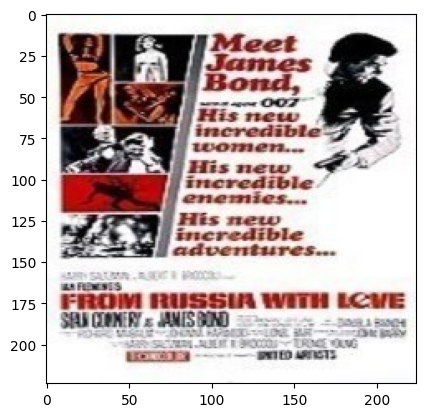

-----------------------------------------------------------------------
most similar products:


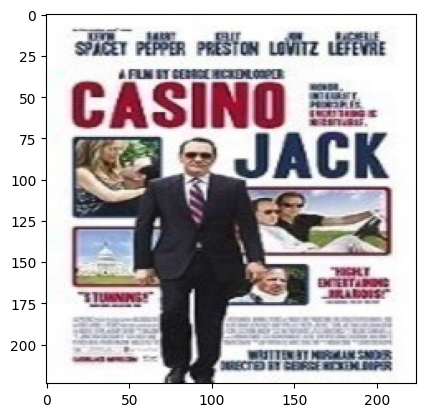

similarity score :  0.72956747


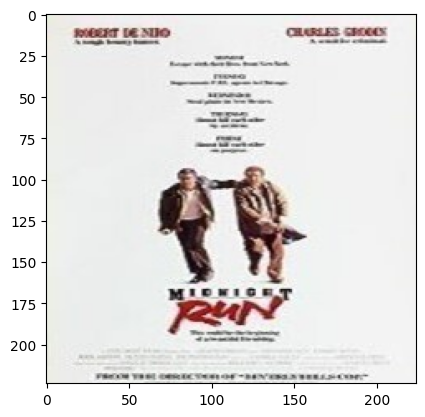

similarity score :  0.7153237


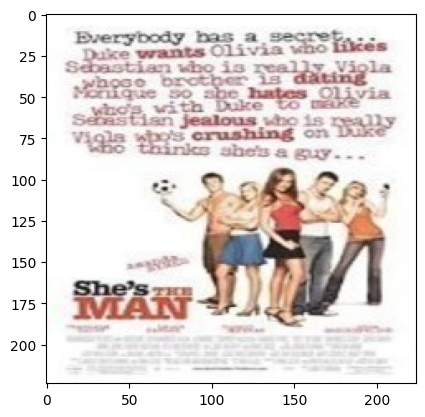

similarity score :  0.70607036


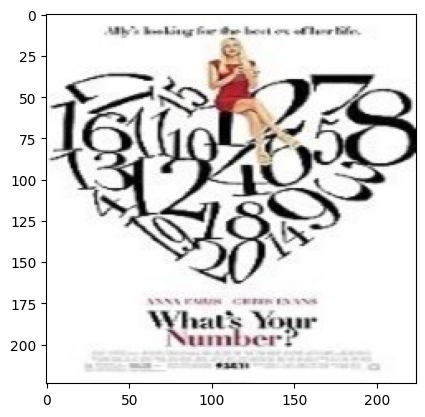

similarity score :  0.70210373


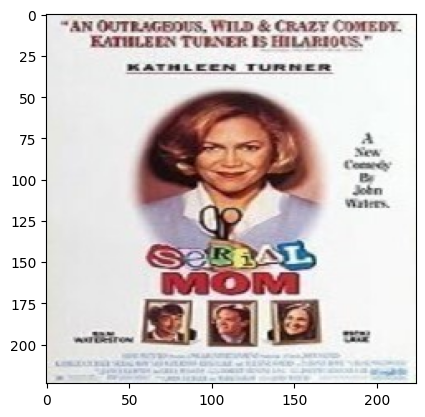

similarity score :  0.69137084


In [49]:
retrieve_most_similar_products(files[0])

-----------------------------------------------------------------------
original product:


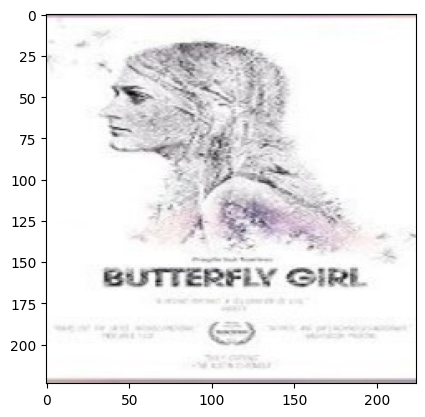

-----------------------------------------------------------------------
most similar products:


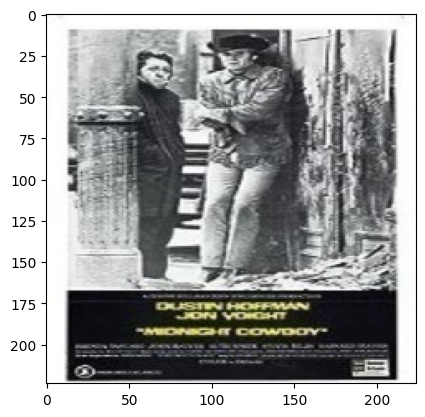

similarity score :  0.64587855


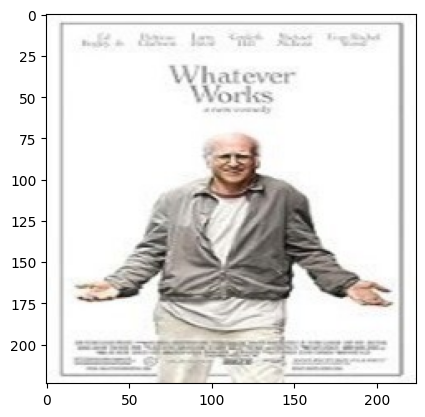

similarity score :  0.6312436


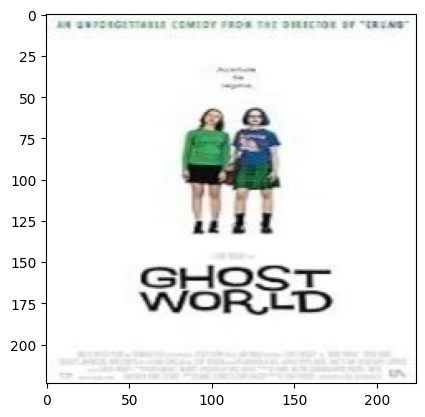

similarity score :  0.62611437


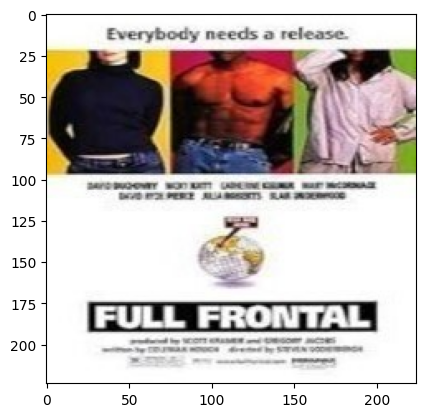

similarity score :  0.6244407


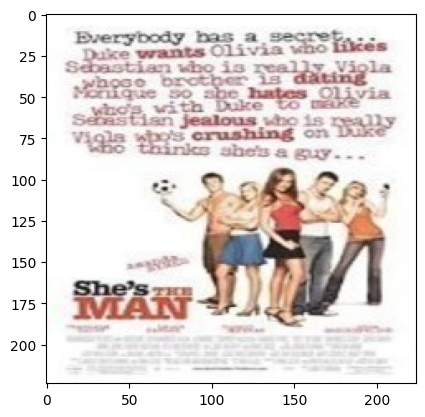

similarity score :  0.621754


In [50]:
retrieve_most_similar_products(files[1])

-----------------------------------------------------------------------
original product:


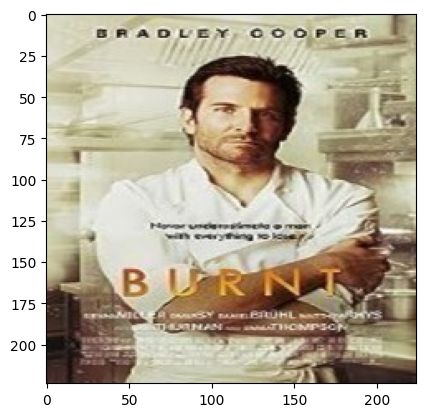

-----------------------------------------------------------------------
most similar products:


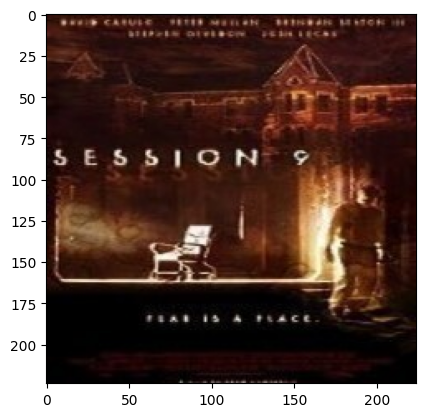

similarity score :  0.5197529


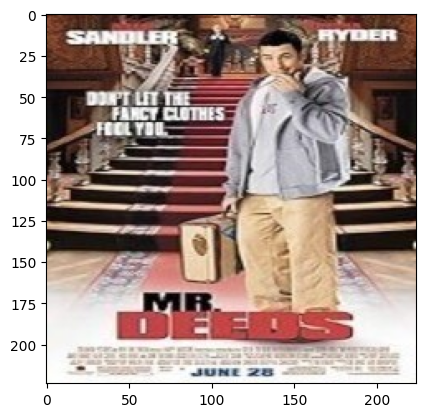

similarity score :  0.5153044


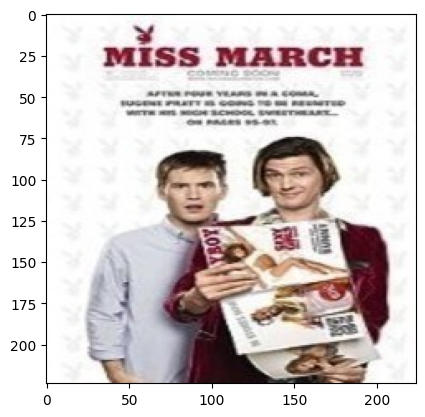

similarity score :  0.5120284


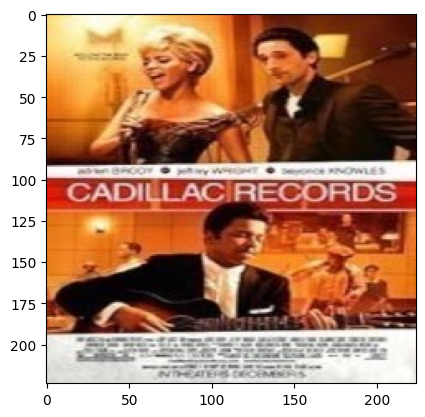

similarity score :  0.50898427


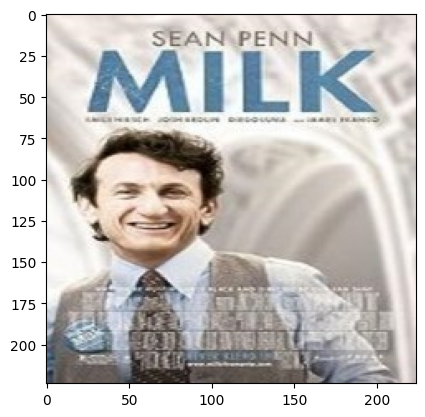

similarity score :  0.49851784


In [51]:
retrieve_most_similar_products(files[2])